In [8]:
#imports

import requests
from bs4 import BeautifulSoup
import random
import json
import re
import folium
import geojson
from IPython.display import display
import matplotlib.pyplot as plt
import unidecode
from shapely.geometry import Polygon
from statistics import mean
import statistics
from folium.plugins import HeatMap

In [9]:
#headers to get html_content
HEADERS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:98.0) Gecko/20100101 Firefox/98.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Cache-Control": "max-age=0",
    }


In [16]:
def calculate_center_coordinates(geometry):
    if geometry["type"] == "MultiPolygon":
        coordinates = geometry["coordinates"][0] 
    elif geometry["type"] == "Polygon":
        coordinates = geometry["coordinates"]
    else:
        raise ValueError("Unsupported geometry type")

    min_lon = min(lon for lon, _ in coordinates[0])
    max_lon = max(lon for lon, _ in coordinates[0])
    min_lat = min(lat for _, lat in coordinates[0])
    max_lat = max(lat for _, lat in coordinates[0])

    center_lon = (min_lon + max_lon) / 2
    center_lat = (min_lat + max_lat) / 2

    return center_lat, center_lon

def get_data_from_page(url):
    r = requests.get(url, headers=HEADERS)
    html_content = r.text
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup

def scrape_prices_and_districts(url, max_pages, max_price=5000000):
    prices_for_each_district = {}
    for page_num in range(1, max_pages + 1):
        url_with_page = f"{url}&page={page_num}"
        soup = get_data_from_page(url_with_page)
        if soup:
            prices = soup.find_all('span', class_='css-1uwck7i e1a3ad6s0')
            streets = soup.find_all('p', class_='css-1dvtw4c e12u5vlm0')
            for price, street in zip(prices, streets):
                price_text = price.get_text()
                matches = re.findall(r'\d+', price_text)
                if matches:
                    price_value = int(''.join(matches))
                    if price_value <= max_price: 
                        district = street.text.strip().split(',')[-3].strip()
                        if district in prices_for_each_district:
                            prices_for_each_district[district].append(price_value)
                        else:
                            prices_for_each_district[district] = [price_value]

        else:
            print("Skipped this page:", page_num)
    return prices_for_each_district


def average_prices_for_each_district(url, max_pages):
    result = scrape_prices_and_districts(url, max_pages)
    average_prices = {}
    for district, prices in result.items():
        average_prices[district] = sum(prices) / len(prices)
    return average_prices


with open('krakow-dzielnice.geojson', 'r', encoding='utf-8') as f:
    geo_data = json.load(f)

url = "https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/malopolskie/krakow/krakow/krakow?viewType=listing&limit=72&page=2"
max_pages = 9
average_prices = average_prices_for_each_district(url, max_pages)


for district, price in average_prices.items():
    print(f"{district}: {price:.2f} PLN")

m = folium.Map(location=[50.0647, 19.9450], zoom_start=12, zoom_control=False)

folium.GeoJson(geo_data,
    style_function=lambda feature: {
        "fillColor": "#ffff00",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    }).add_to(m)

heat_data = []
for feature in geo_data['features']:
    district_name = feature['properties']['name']
    center_lat, center_lon = calculate_center_coordinates(feature['geometry'])
    average_price = average_prices.get(district_name, 0)  
    heat_data.append([center_lat, center_lon, average_price])

HeatMap(heat_data).add_to(m)

display(m)

Bieńczyce: 576988.89 PLN
Bieżanów-Prokocim: 753307.69 PLN
Krowodrza: 908373.94 PLN
Bronowice: 597800.00 PLN
Podgórze: 796755.88 PLN
Prądnik Biały: 842496.54 PLN
Dębniki: 988075.67 PLN
Czyżyny: 760947.37 PLN
Mistrzejowice: 744999.50 PLN
Swoszowice: 640500.00 PLN
Podgórze Duchackie: 634000.00 PLN
Grzegórzki: 832827.59 PLN
Stare Miasto: 800056.00 PLN
Zwierzyniec: 1807408.93 PLN
Nowa Huta: 683631.58 PLN
Wzgórza Krzesławickie: 777909.00 PLN
Prądnik Czerwony: 751858.33 PLN
Łagiewniki-Borek Fałęcki: 963300.00 PLN


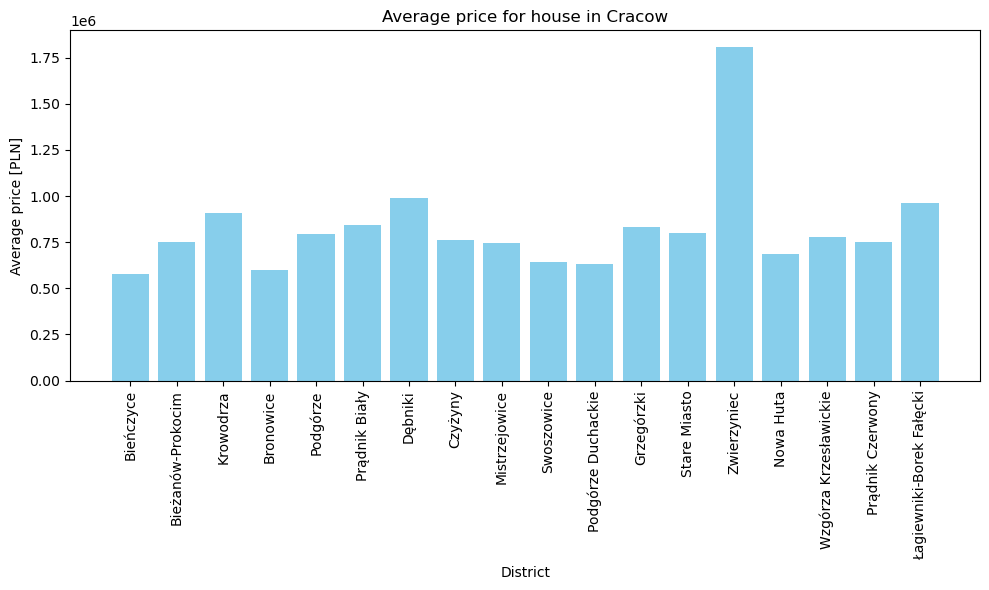

In [17]:
districts = list(average_prices.keys())
average_prices_values = list(average_prices.values())

plt.figure(figsize=(10, 6))
plt.bar(districts, average_prices_values, color='skyblue')
plt.xlabel('District')
plt.ylabel('Average price [PLN]')
plt.title('Average price for house in Cracow')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
def get_prices_per_meter(url, max_pages):
    price_list = []
    districts = []
    for page_num in range(1, max_pages + 1):
        url_with_page = f"{url}&page={page_num}"
        soup = get_data_from_page(url_with_page)
        prices = soup.find_all(class_='css-1c1kq07 e12r8p6s0')
        streets = soup.find_all('p', class_='css-1dvtw4c e12u5vlm0')
        for price, street in zip(prices, streets):
            district = street.text.strip().split(',')[-3].strip()
            price_pattern = r'Cena za metr kwadratowy([\d\s]+)zł/m²'
            price_match = re.search(price_pattern, price.get_text())
            if price_match:
                price_to_print = price_match.group(1)
                clean_price = unidecode.unidecode(price_to_print)
                price_list.append(float(clean_price.replace(" ", "")))
                districts.append(district)
                #print(price_to_print + "" + district)
            else:
                continue
    return districts, price_list


def average_prices_for_each_district_per_meter(url, max_pages):
    districts, price_list = get_prices_per_meter(url, max_pages)
    average_arr = []
    unique_districts = list(set(districts))  
    for district in unique_districts:
        prices_for_district = [price_list[i] for i in range(len(districts)) if districts[i] == district]
        average = sum(prices_for_district) / len(prices_for_district)
        average_arr.append(average)
        #print(f"{district} {average}")
        
    return average_arr, unique_districts
    
    
    

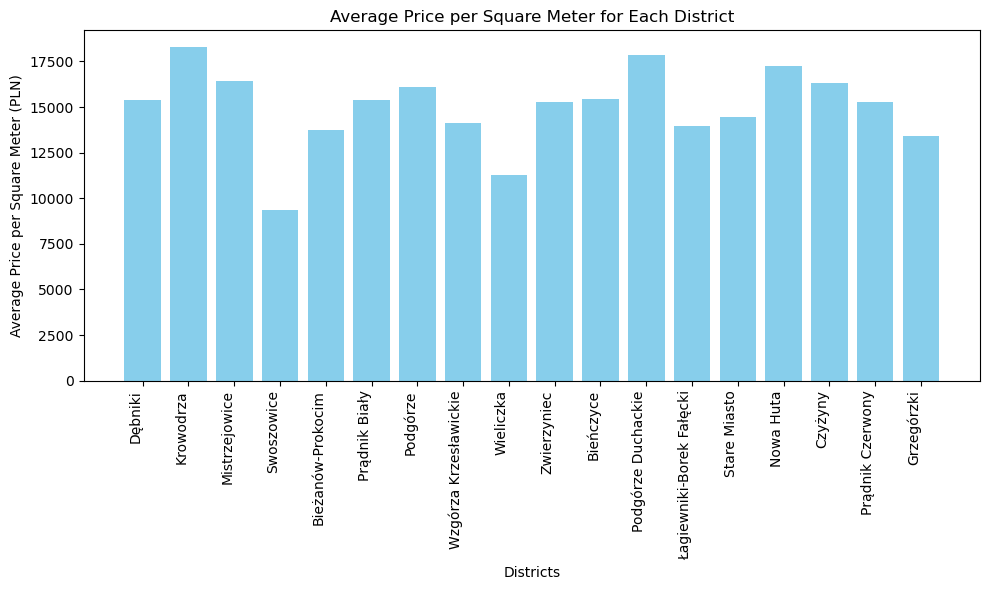

In [49]:
url = "https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/malopolskie/krakow/krakow/krakow?viewType=listing&limit=72&page=2"
average_prices, unique_districts = average_prices_for_each_district_per_meter(url, 10)


plt.figure(figsize=(10, 6))
plt.bar(unique_districts, average_prices, color='skyblue')
plt.xlabel('Districts')
plt.ylabel('Average Price per Square Meter (PLN)')
plt.title('Average Price per Square Meter for Each District')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()